In [2]:
print('Takumi House & Kailen Santos')

Takumi House & Kailen Santos


Our original pitch was the following: <br>
People rarely report cases of food poisoning to the appropriate government bodies. However, they are more likely to post on restaurant review apps like Yelp, sharing their negative experiences. <br>
Our plan is to use the Yelp API to search for key terms like ‘sick’, ‘food poisoning’, ‘nausea’, ‘throw up’ to see if there are any restaurants in the Boston area that have noticeably high-frequency reports of cases of food poisoning. Then, we will cross reference them with the Boston Health Inspection dataset from the Boston Inspectional Services Department see if there are any restaurants that are slipping through the cracks of the health inspectors, and whether or not we can predict at which restaurants patrons are most at risk. We can then see if there are certain locations, or certain kinds of restaurants, that seem to result in higher numbers of food safety infractions. <br>
Our first challenge came with the Yelp API. Due to registration issues and limitations of the API, we realized quickly that the API was not capable of carrying out our proposed project, even though we had data regarding health inspection data from the City of Boston Open Data Portal. We looked into the use of other APIs, like the FourSquare API, which was more user-friendly and could provide us with full text reviews of restaurants. Although the businesses on the FourSquare API had fewer users, and therefore fewer reviews, we were optimistic that we could still make use of the data. We started caching the data information returned by the FourSquare API, but soon realized that, although there was a fair amount of traffic on any given business, the total number of businesses registered on FourSquare were far fewer in number. The FourSquare API also lacks a pagination parameter, which made a complete scrape of Boston's restaurants difficult. <br>
Upon Professor Terzi's recommendation, we turned to the Yelp Academic Dataset. We were hesitant at first to use the Academic Dataset, namely due to the fact that the information is static, and as mentioned on the Yelp Dataset Challenge page, the dataset is made up of \"Only the reviews that Yelp recommended at the time of data collection.\" We were concerned, due to past reports of unfair review filtering on Yelp's part, that this may have meant that there was a bias in the data towards positive reviews. However, upon further inspection, it appears that recommended reviews are reviews that best indicate the average opinion of the business, and would therefore be a good indicator of public opinion. This means that we won't get all of the reviews for every business, but we are hopeful that there are telling reviews within this subset. The dataset was first released in 2013, but was updated most recently in January of 2017. Unlike the API, the Academic Dataset offered full text reviews, which is crucial to the success of our project. We decided to use Las Vegas as our test city because Las Vegas has their own Open Data Portal, where we found a Restaurant Inspections Dataset within their Public Safety Division. Similar to the one found for Boston, it contains restaurants, violations, ensuing consequences, etc. This is perfect for our comparisons. Additionally, Las Vegas has more than twice the number of restaurants than the second most frequent city in the dataset, and more than three times the number of reviews than the second most frequent city in the dataset.

In [83]:
from matplotlib import pyplot as plt
import matplotlib as mp
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import sklearn.manifold
from scipy import cluster
import seaborn as sns
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import requests
import json
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
import re
import json
import pickle
%matplotlib inline

We begin by cleaning the academic dataset of irrelevant business. We only want too look at restaurants in Las Vegas, so we iterate through all of the json objects and filter out the unneeeded businesses, and add them to a list names.

In [4]:
restaurants = {}
names=[]
with open('yelp_academic_dataset_business.json') as data:
    for i in data:
        d = json.loads(i)
        if (d['city']=='Las Vegas'):
            if ('Restaurants' in d['categories']):
                restaurants[d['business_id']] = {'latitude':d['latitude'], 'longitude':d['longitude']}
                names.append(d['name'])
# restaurants

In [5]:
bId = []
long = []
lat = []

for x, y in restaurants.items():
    bId.append(x)
    long.append((y.get('longitude')))
    lat.append((y.get('latitude')))
long = np.array(long)
lat = np.array(lat)

print(long)
print(lat)

[-115.1696112  -115.062908   -115.285177   ..., -115.17935466 -115.24209473
 -115.1645622 ]
[ 36.1214517   36.1004362   36.158503   ...,  36.10702823  36.04170546
  36.1314967 ]


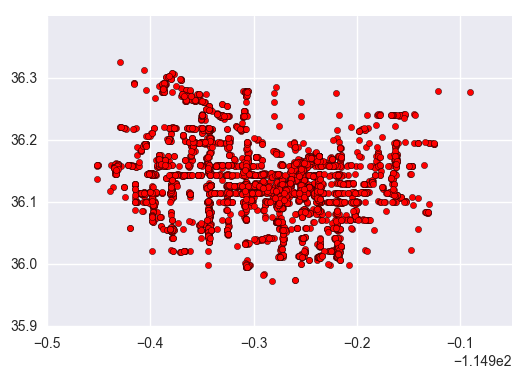

In [6]:
plt.scatter(long, lat, c='red', s=20)

In [7]:
# file = 'Restaurant_Inspections.json'
# data = []
# with open(file) as f:
#     for line in f:
#         data.append(json.loads(line))

We read in the Restaurant Inspections dataset into a pandas dataframe.

In [8]:
df = pd.read_csv('Restaurant_Inspections.csv',header=0)
# df = df[df.City == 'Las Vegas']
# df = (df[df['Inspection Result'] == 'Closed with Fees']).append(df[df['Inspection Result'] == 'Closed without Fees'])

df.shape

#with open ('Resaurant_Inspections.csv') as file:
#   for line in file:
#      if (line[6]=='Las Vegas' && line[]

/Users/takumihouse/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(123919, 23)

We begin cleaning the dataset by checking the cities in which these health inspections took place. Although this dataset is from the Las Vegas Open Data Portal, it contains data from restaurants all around Nevada, as far as 70 miles from the city.
I decide to do this in a step by step process, making sure to check how many lines are removed by every parameter.

In [9]:
df = df[df.City == 'Las Vegas']
df.shape

(94700, 23)

Next, we clean the dataset of health code inspections that do not pertain to restaurants. <br> We define restaurants to be: <br> Places of business open to the public who serve food in exchange for monetary payment. <br> Therefore, we remove the categories that do no adhere to these standards.

In [10]:
categories = df['Category Name'].unique().tolist()
print(categories)

['Pantry', 'Special Kitchen', 'Garde Manger', 'Kitchen Bakery', 'Bar / Tavern', 'Buffet', 'Snack Bar', 'Restaurant', 'Banquet Support', 'Portable Unit', 'Banquet Kitchen', 'Portable Bar', 'Meat/Poultry/Seafood', 'Vegetable Prep', 'Caterer', 'Barbeque', 'Confection', 'Concessions', 'Produce Market', 'Institutional Food Service', 'Elementary School Kitchen', 'Self-Service Food Truck', 'Bakery Sales', 'Food Trucks / Mobile Vendor', 'Grocery Store Sampling', 'Beer Bar', 'Childcare Kitchens', "Farmer's Market", 'Main Kitchen', 'Frozen Meat Sales']


In [11]:
categories.remove('Elementary School Kitchen')
categories.remove('Grocery Store Sampling')
categories.remove('Farmer\'s Market')
categories.remove('Caterer')
categories.remove('Concessions')
categories.remove('Institutional Food Service')
categories.remove('Banquet Support')

In [12]:
df = df[df['Category Name'].isin(categories)]
df.shape

(91735, 23)

In [13]:
coord_strings = df['Location 1'].tolist()

We convert our points from strings to the appropriate float tuple format, and plot our points to see what our spread of inspec looks like.

In [14]:
import ast
xcoords = []
ycoords = []
for coord in coord_strings:
    xcoords.append(ast.literal_eval(coord)[0])
    ycoords.append(ast.literal_eval(coord)[1])

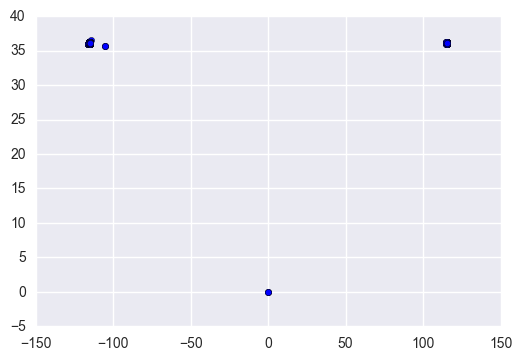

In [15]:
plt.scatter(ycoords, xcoords, c = 'b')

It is evident that there are some outlier coordinates. We aren't certain whether these are due to input errors, or because our cleaning was not sufficient.

Upon further inspection, we realize that some of the y coordinates have erroneously been negated, from ~-115 to ~115. We iterate through the dataset and fix the offending coordinates.

In [16]:
count = 0
for idx, ycoord in enumerate(ycoords):
    if ycoord > 0:
        ycoords[idx] = ycoord * -1
        count += 1
print('{} coordinates fixed.'.format(count))

574 coordinates fixed.


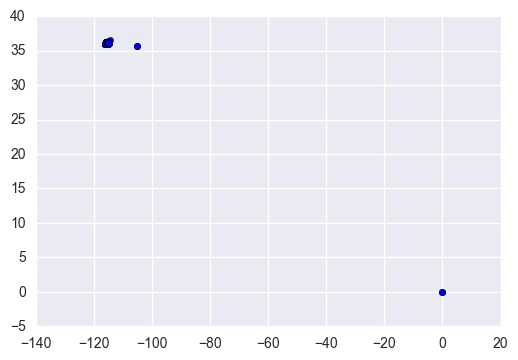

In [17]:
plt.scatter(ycoords, xcoords, c = 'b')

That's better, but it looks like there are a few points at (0,0), likely because coordinate information wasn't provided.

In [18]:
# df = df[df['Location 1'] != '(0, 0)']
df['Coordinates'] = list(zip(xcoords, ycoords))
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Employee ID,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000567,Routine Inspection,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,EE7000417,Routine Inspection,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000392,Routine Inspection,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"


In [19]:
df = df[df['Coordinates'] != (0,0)]
# df = df[df['Coordinates'][1] < -112]
df.shape

(91732, 24)

Creating Series in the df for ease of use when checking coordinate limits.

In [20]:
coordinates_list = df['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])
df['X'] = xcoords
df['Y'] = ycoords
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058


Based on maps and resources online, and the spread of our reviews, we set upper and lower limits, which is an area of approximately 100 km, more enough to include all of Las Vegas.

In [27]:
df = df[df['Y'] < -114.5]
df = df[df['Y'] > -115.6]
df.shape

(91701, 26)

In [28]:
df_clean = df.reset_index(drop = True)
df_clean.shape

(91701, 26)

In [29]:
coordinates_list = df_clean['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])

The new plot of health inspection reports.

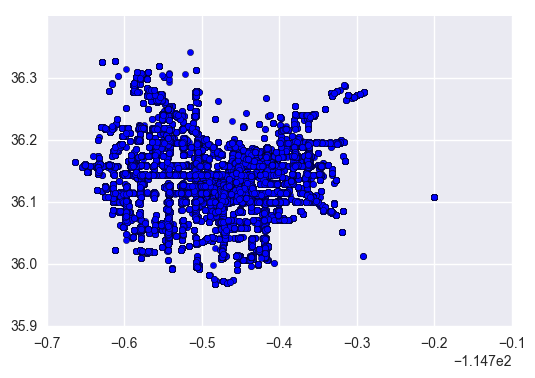

In [30]:
plt.scatter(ycoords, xcoords, c = 'b')

A plot of health inspection reports overlayed on th set of restaurants in the academic dataset. It looks like a fairly good spread.

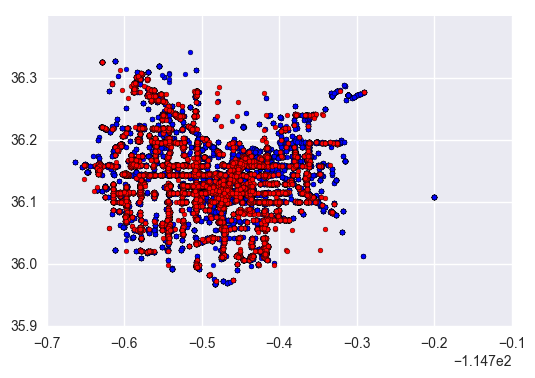

In [31]:
plt.scatter(ycoords, xcoords, c = 'b', s=12)
plt.scatter(long, lat, c='r', s=12)

After visualizing the spread resulting from the plot above, we aggregate the violation data by restaurant.

In [32]:
df_agg = df.groupby('Restaurant Name',as_index=False).agg(lambda x: x.tolist())

In [31]:
dfcategories = df_agg.columns
for x in dfcategories[1:]:
    for y in range(len(df_agg[x])):
        df_agg[x][y] = list(set(df_agg[x][y]))

In [32]:
for x in dfcategories[22:]:
    for y in range(len(df_agg[x])):
        df_agg[x][y] = df_agg[x][y][0]

In [33]:
df_agg

,Restaurant Name,Serial Number,Permit Number,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
0,#1 HAWAIIAN BARBEQUE,"[DAO2OUCAK, DA1280233, DAZ0OBT0B, DA1444962, D...",[PR0110047],[CHINA DRAGON/#1 HAWAIIAN BARBEQUE],[Restaurant],[5905 S EASTERN Ave 105],[Las Vegas],[Nevada],[89119],[9],...,"[0, 3, 6, 8, 9, 17, 19, 20, 27]","[nan, B, A, C]","[nan, B, A]","['A' Grade, Compliant, 'B' Downgrade, 'C' Down...","[nan, 20921129292930, 211215292829302955, 2022...","[01/20/2017 03:52:29 PM, 06/09/2015 09:52:01 A...","(36.0820114, -115.119644)","(36.0820114, -115.119644)",36.082,-115.12
1,$5 CAFE,"[DA1280693, DA1640753, DADY9VZ5M, DA1510775]",[PR0017837],[AZTEC INN - $5 CAFE],[Restaurant],[2200 S Las Vegas Blvd],[Las Vegas],[Nevada],[89104-2527],[10],...,"[8, 10, 6]",[A],"[nan, A]","['A' Grade, Compliant]","[2022172912, 21129092910, 20229292955, 2022062...","[01/18/2017 08:53:37 AM, 09/17/2014 08:43:23 A...","(36.1459136, -115.1561175)","(36.1459136, -115.1561175)",36.1459,-115.156
2,100 DEGREES HOT POT - DELETED 10/15,"[DA1500853, DA1494935]",[PR0113718],[100 DEGREES HOT POT],[Restaurant],[5600 SPRING MOUNTAIN Rd B],[Las Vegas],[Nevada],[89146],[3],...,"[3, 20]","[B, A]",[nan],"[Compliant, 'B' Downgrade]","[20821521829092912292929552956, 2122911]","[04/15/2015 09:57:26 AM, 04/29/2015 01:02:30 PM]","(36.1265084, -115.2182851)","(36.1265084, -115.2182851)",36.1265,-115.218
3,101 MART SNACK BAR,"[DATYVW3XN, DAV0HMPRO]",[PR0118514],[101 MART],[Snack Bar],[1021 CONVENTION CENTER Dr],[Las Vegas],[Nevada],[89109],[6],...,"[3, 6]",[A],"[nan, A]",['A' Grade],"[291229282955, 2152955]","[07/26/2016 02:15:51 PM, 04/10/2017 03:52:34 PM]","(36.1322288, -115.1553506)","(36.1322288, -115.1553506)",36.1322,-115.155
4,168 Market - Bakery,"[DA0629041, DA1006944, DAHDRCSW0, DA1106115, D...",[PR0021447],[168 Market],[Bakery Sales],[3459 S Jones Blvd],[Las Vegas],[Nevada],[89146-6729],[3],...,"[0, 3, 5, 6, 7, 8, 9, 19]","[B, A]","[nan, nan, nan, nan]","['A' Grade, Compliant, 'B' Downgrade]","[nan, 215290929282956, 2112930, 1964, 27113, 2...","[06/17/2015 10:48:28 AM, 07/05/2016 11:58:46 A...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225
5,168 Market - Restaurant,"[DAYNKASGU, DA0629031, DABVJVIX6, DA1573743, D...",[PR0021446],[168 Market],[Restaurant],[3459 S Jones Blvd],[Las Vegas],[Nevada],[89146-6729],[0],...,"[0, 1, 3, 7, 9, 16, 17, 23, 30]","[B, C, A]","[nan, nan, nan, nan, nan, nan, nan, A, B]","['A' Grade, Compliant, 'B' Downgrade, 'C' Down...","[nan, 211290929112927292929302955, 31, 2112152...","[09/28/2015 09:02:17 AM, 03/13/2015 12:12:31 P...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225
6,168 Market / Produce Department,"[DAQHWMY0C, DA1293459, DA1075271, DA0627520, D...",[PR0021445],[168 Market],[Produce Market],[3459 S Jones Blvd],[Las Vegas],[Nevada],[89146-6729],[6],...,"[2, 3, 6, 8, 9, 17]","[B, A]","[nan, nan, nan, nan]","['A' Grade, Compliant, 'B' Downgrade]","[nan, 2042112122152202910, 2907, 202233, 29092...","[07/28/2016 11:48:33 AM, 05/30/2013 02:11:36 P...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225
7,17 SOUTH BOOZE & BITES BAR,"[DA1520777, DA1198905, DA1687910]",[PR0109450],[Tahiti Village],[Bar / Tavern],[7200 S Las Vegas Blvd],[Las Vegas],[Nevada],[89119-4020],[0],...,"[0, 3]",[A],[nan],[Compliant],"[nan, 2912, 218]","[05/25/2016 03:23:33 PM, 06/09/2015 02:27:58 P...","(36.0596893, -115.1715274)","(36.0596893, -115.1715274)",36.0597,-115.172
8,17 SOUTH BOOZE & BITES GRILL,"[DA1200357, DA1304346, DAHDHKWVP, DAOFY1WMS, D...",[PR0109449],[Tahiti Village],[Restaurant],[7200 S Las Vegas Blvd],[Las Vegas],[Nevada],[89119-4020],[9],...,"[0, 3, 38, 6, 9, 10, 14, 16, 19]","[B, A, C]","[nan, B, A]","['A' Grade, Compliant, 'B' Downgrade, 'C' Down...","[291229272955, 2182930, 2062092112122956, 2927...","[11/17/201

In [37]:
for x in dfcategories[1:22]:
    for y in range(len(df_agg[x])):
        if (isinstance(df_agg[x][y][0], float) or isinstance(df_agg[x][y][0], np.int64)):
            df_agg[x][y] = ''.join((str(e) +', ' for e in df_agg[x][y])
        else:
            df_agg[x][y] = ''.join(str(df_agg[x][y]))

In [38]:
df_agg

,Restaurant Name,Serial Number,Permit Number,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
0,#1 HAWAIIAN BARBEQUE,DAO2OUCAKDA1280233DAZ0OBT0BDA1444962DA1446127D...,PR0110047,CHINA DRAGON/#1 HAWAIIAN BARBEQUE,Restaurant,5905 S EASTERN Ave 105,Las Vegas,Nevada,89119,9,...,0368917192027,nanBAC,nanBA,"[""'A' Grade"", 'Compliant', ""'B' Downgrade"", ""'...",nan2092112929293021121529282930295520220821529...,"['01/20/2017 03:52:29 PM', '06/09/2015 09:52:0...","(36.0820114, -115.119644)","(36.0820114, -115.119644)",36.082,-115.12
1,$5 CAFE,DA1280693DA1640753DADY9VZ5MDA1510775,PR0017837,AZTEC INN - $5 CAFE,Restaurant,2200 S Las Vegas Blvd,Las Vegas,Nevada,89104-2527,10,...,8106,['A'],nanA,"[""'A' Grade"", 'Compliant']","['2022172912', '21129092910', '20229292955', '...","['01/18/2017 08:53:37 AM', '09/17/2014 08:43:2...","(36.1459136, -115.1561175)","(36.1459136, -115.1561175)",36.1459,-115.156
2,100 DEGREES HOT POT - DELETED 10/15,DA1500853DA1494935,PR0113718,100 DEGREES HOT POT,Restaurant,5600 SPRING MOUNTAIN Rd B,Las Vegas,Nevada,89146,3,...,320,"['B', 'A']",nan,"['Compliant', ""'B' Downgrade""]","['20821521829092912292929552956', '2122911']","['04/15/2015 09:57:26 AM', '04/29/2015 01:02:3...","(36.1265084, -115.2182851)","(36.1265084, -115.2182851)",36.1265,-115.218
3,101 MART SNACK BAR,DATYVW3XNDAV0HMPRO,PR0118514,101 MART,Snack Bar,1021 CONVENTION CENTER Dr,Las Vegas,Nevada,89109,6,...,36,['A'],nanA,"[""'A' Grade""]","['291229282955', '2152955']","['07/26/2016 02:15:51 PM', '04/10/2017 03:52:3...","(36.1322288, -115.1553506)","(36.1322288, -115.1553506)",36.1322,-115.155
4,168 Market - Bakery,DA0629041DA1006944DAHDRCSW0DA1106115DA0627523D...,PR0021447,168 Market,Bakery Sales,3459 S Jones Blvd,Las Vegas,Nevada,89146-6729,3,...,035678919,"['B', 'A']",nannannannan,"[""'A' Grade"", 'Compliant', ""'B' Downgrade""]",nan2152909292829562112930196427113209217217209...,"['06/17/2015 10:48:28 AM', '07/05/2016 11:58:4...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225
5,168 Market - Restaurant,DAYNKASGUDA0629031DABVJVIX6DA1573743DA0965352D...,PR0021446,168 Market,Restaurant,3459 S Jones Blvd,Las Vegas,Nevada,89146-6729,0,...,0137916172330,"['B', 'C', 'A']",nannannannannannannanAB,"[""'A' Grade"", 'Compliant', ""'B' Downgrade"", ""'...",nan2112909291129272929293029553121121529092910...,"['09/28/2015 09:02:17 AM', '03/13/2015 12:12:3...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225
6,168 Market / Produce Department,DAQHWMY0CDA1293459DA1075271DA0627520DA0627521D...,PR0021445,168 Market,Produce Market,3459 S Jones Blvd,Las Vegas,Nevada,89146-6729,6,...,2368917,"['B', 'A']",nannannannan,"[""'A' Grade"", 'Compliant', ""'B' Downgrade""]",nan2042112122152202910290720223329092911292818...,"['07/28/2016 11:48:33 AM', '05/30/2013 02:11:3...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225
7,17 SOUTH BOOZE & BITES BAR,DA1520777DA1198905DA1687910,PR0109450,Tahiti Village,Bar / Tavern,7200 S Las Vegas Blvd,Las Vegas,Nevada,89119-4020,0,...,03,['A'],nan,['Compliant'],nan2912218,"['05/25/2016 03:23:33 PM', '06/09/2015 02:27:5...","(36.0596893, -115.1715274)","(36.0596893, -115.1715274)",36.0597,-115.172
8,17 SOUTH BOOZE & BITES GRILL,DA1200357DA1304346DAHDHKWVPDAOFY1WMSDA1687887D...,PR0109449,Tahiti Village,Restaurant,7200 S Las Vegas Blvd,Las Vegas,Nevada,89119-4020,9,...,03386910141619,"['B', 'A', 'C']",nanBA,"[""'A' Grade"", 'Compliant', ""'B' Downgrade"", ""'...","['291229272955', '2182930', '2062092112122956'...","['11/17/2016 11:20:43 AM', '11/12/2014 02:51:2...","(36.0596893, -115.1715274)","(36.0596893, -115.1715274)",36.0597,-115.172
9,1900 ASIAN CUISINE,DA1121025DA1100071DA1099088DA1086357DA1114253,PR0099062,1900 ASIAN CUISINE,Restaurant,5115 Spring Mountain Rd 103,Las Vegas,Nevada,89146,0,...,824031,"['C', 'A', 'X']",

In [ ]:
df_agg.sort_values(df_agg)

In [37]:
file = 'yelp_academic_dataset_business.json'
business_locations = {}
lv_restaurant_ids = []
with open(file) as f:
    for line in f:
        r_line = json.loads(line)
        business_locations.update({r_line['business_id']:r_line['city']})
        if 'Restaurants' in r_line['categories']:
            lv_restaurant_ids.append(r_line['business_id'])

In [38]:
len(business_locations)

77445

In [39]:
len(lv_restaurant_ids)

25071

In [8]:
# data = []
# file = 'yelp_academic_dataset_review.json'
# # df_reviews = pd.read_json(file, lines=True)
# with open(file) as f:
#     for line in f:
#         r_line = json.loads(line)
#         data.append(r_line)
# # for business in filtered_category_data:
# # #     r_line = json.loads(line)
# #     restaurant_count[business['city']] += 1

before running the next cell, run the pickle.load cell a few cells down

In [21]:
# read the entire file into a python array
file = 'yelp_academic_dataset_review.json'

# with open(file) as f:
#     for line in f:
#         r_line = json.loads(line)

with open(file, 'r') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df_reviews = pd.read_json(data_json_str)

In [22]:
df_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,votes
0,5UmKMjUEUNdYWqANhGckJw,2012-08-01,Ya85v4eqdd6k9Od8HbQjyA,4,"Mr Hoagie is an institution. Walking in, it do...",review,PUFPaY9KxDAcGqfsorJp3Q,"{'cool': 0, 'funny': 0, 'useful': 0}"
1,5UmKMjUEUNdYWqANhGckJw,2014-02-13,KPvLNJ21_4wbYNctrOwWdQ,5,Excellent food. Superb customer service. I mis...,review,Iu6AxdBYGR4A0wspR9BYHA,"{'cool': 0, 'funny': 0, 'useful': 0}"
2,5UmKMjUEUNdYWqANhGckJw,2015-10-31,fFSoGV46Yxuwbr3fHNuZig,5,Yes this place is a little out dated and not o...,review,auESFwWvW42h6alXgFxAXQ,"{'cool': 0, 'funny': 0, 'useful': 0}"
3,UsFtqoBl7naz8AVUBZMjQQ,2013-11-08,Di3exaUCFNw1V4kSNW5pgA,5,All the food is great here. But the best thing...,review,uK8tzraOp4M5u3uYrqIBXg,"{'cool': 0, 'funny': 0, 'useful': 0}"
4,UsFtqoBl7naz8AVUBZMjQQ,2014-03-29,0Lua2-PbqEQMjD9r89-asw,3,We checked this place out this past Monday for...,review,I_47G-R2_egp7ME5u_ltew,"{'cool': 0, 'funny': 0, 'useful': 0}"


In [23]:
df_reviews['city'] = df_reviews['business_id'].map(business_locations)

In [24]:
df_reviews.shape

(2225213, 9)

In [25]:
vegas_cities = ['Las Vegas', 'North Las Vegas', 'N Las Vegas', 'Las Vegas ', 'N. Las Vegas']
df_reviews = df_reviews[df_reviews['city'].isin(vegas_cities)]

In [27]:
df_reviews.shape

(878143, 9)

In [40]:
df_reviews = df_reviews[df_reviews['business_id'].isin(lv_restaurant_ids)]

In [41]:
df_reviews.shape

(510647, 9)

run following cell to get df_reviews before anything else

In [90]:
try:
    with open('df_reviews','rb') as f:
        df_reviews = pickle.load(f)
        
except FileNotFoundError:
    with open('df_reviews','wb') as f:
        pickle.dump(df_reviews, f)

In [42]:
df_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,votes,city
176038,_SM8UKIwBNbmj1r629ipoQ,2008-01-27,q63uf05O8LJjjPiv8YqMLg,4,"I like Chianti, the outdoor seating area is ni...",review,RZwkUvViHYEh5Z65--cVZw,"{'cool': 3, 'funny': 1, 'useful': 3}",Las Vegas
176039,_SM8UKIwBNbmj1r629ipoQ,2008-08-13,FDTrDJbM-MSzVNsx2d5b7A,4,My wife and I went to Chianti for our annivers...,review,mW0l2ZhDeAAgjXPz_x2qRQ,"{'cool': 1, 'funny': 0, 'useful': 0}",Las Vegas
176040,_SM8UKIwBNbmj1r629ipoQ,2009-02-25,Z3MdiHyqJNV5Q6-SZtnCEg,5,We just enjoyed yet another wonderful dinner a...,review,SM2YJDFjrjx5LyVEprAtyw,"{'cool': 0, 'funny': 0, 'useful': 0}",Las Vegas
176041,_SM8UKIwBNbmj1r629ipoQ,2009-06-09,PL0YjA42hESdNG4GQgipGQ,4,We were in the Las Vegas / Summerlin area and ...,review,9fNSDDVlMCTA5b2xKL4ARw,"{'cool': 0, 'funny': 0, 'useful': 0}",Las Vegas
176042,_SM8UKIwBNbmj1r629ipoQ,2009-06-25,Jw2QVGxmSyPdZrWWqaJLZg,5,I live very close by to this place and am so g...,review,CioAnuJ5rF2dCpVZsNVCwA,"{'cool': 2, 'funny': 0, 'useful': 1}",Las Vegas


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(df_reviews['text'])

try:
    with open('stemmed_data','rb') as f:
        stemmed_data = pickle.load(f)
        
except FileNotFoundError:
    stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in df_reviews['text']]
    
    with open('stemmed_data','wb') as f:
        pickle.dump(stemmed_data, f)

In [46]:
print(type(dtm), dtm.shape)
terms = vectorizer.get_feature_names()
print(terms)

<class 'scipy.sparse.csr.csr_matrix'> (510647, 48982)
['00', '000', '001', '007', '00a', '00am', '00ish', '00p', '00pm', '00s', '01', '01am', '01pm', '02', '02pm', '03', '03pm', '04', '0400', '04pm', '05', '05am', '05pm', '06', '0600', '06pm', '07', '0700', '07am', '08', '08am', '08pm', '09', '0900', '0930', '09pm', '0_o', '0d', '0p', '0z', '10', '100', '1000', '10000', '100000', '10000x', '1000s', '1000x', '100f', '100ft', '100lbs', '100m', '100oz', '100pp', '100s', '100th', '100x', '101', '1015', '1015am', '1015pm', '102', '103', '1030', '1030a', '1030am', '1030ish', '1030p', '1030pm', '104', '1045', '1045pm', '105', '1050', '106', '106th', '107', '107th', '108', '109', '10a', '10am', '10bucks', '10days', '10ea', '10ft', '10ish', '10k', '10lbs', '10m', '10min', '10mins', '10minute', '10minutes', '10oz', '10p', '10pc', '10pm', '10pp', '10ppl', '10s', '10stars', '10th', '10x', '10x10', '10years', '10yrs', '11', '110', '1100', '111', '1115', '112', '113', '1130', '1130a', '1130am', '113

In [80]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize



# stemmed_data = news_data.data

In [87]:
try:
    with open('stemmed_data','rb') as f:
        stemmed_data = pickle.load(f)
        
except FileNotFoundError:
    stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in df_reviews['text']]
    
    with open('stemmed_data','wb') as f:
        pickle.dump(stemmed_data, f)

In [81]:
dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names()
print(terms)

['00', '000', '001', '007', '00a', '00am', '00ish', '00p', '00pm', '00s', '01', '01am', '01pm', '02', '02pm', '03', '03pm', '04', '0400', '04pm', '05', '05am', '05pm', '06', '0600', '06pm', '07', '0700', '07am', '08', '08am', '08pm', '09', '0900', '0930', '09pm', '0_o', '0d', '0p', '0z', '10', '100', '1000', '10000', '100000', '10000x', '1000s', '1000x', '100f', '100ft', '100lbs', '100m', '100oz', '100pp', '100s', '100th', '100x', '101', '1015', '1015am', '1015pm', '102', '103', '1030', '1030a', '1030am', '1030ish', '1030p', '1030pm', '104', '1045', '1045pm', '105', '1050', '106', '106th', '107', '107th', '108', '109', '10a', '10am', '10buck', '10day', '10ea', '10ft', '10ish', '10k', '10lbs', '10m', '10min', '10minut', '10oz', '10p', '10pc', '10pm', '10pp', '10ppl', '10s', '10star', '10th', '10x', '10x10', '10year', '10yr', '11', '110', '1100', '111', '1115', '112', '113', '1130', '1130a', '1130am', '1130pm', '114', '1145', '1145am', '115', '116', '117', '118', '119', '11a', '11am', '1

In [56]:
core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
count = 0
sick_review = []
for review in df_reviews['text']:
    if any(keyword in review for keyword in keywords):
        sick_review.append(review)
        count += 1
print(count)

7443


In [57]:
count = 0
core_sick_review = []
for review in df_reviews['text']:
    if any(keyword in review for keyword in core_keywords):
        core_sick_review.append(review)
        count += 1
print(count)

5662


In [44]:
print(sick_review[:10])

["First impression was nice.  The hostess was very friendly and professional. She greeted us and offered us a carrier for our babies car seat so that was a plus.  She sat us down and not to long after we had our waiter take our drinks. They handed us chips and salsa right away. We placed our order and munched on the chips and salsa which was pretty yummy.  But the wait just to get our food was pretty lengthy. We ended up getting full off of the food because of the wait. So when our food finally came it was nice and hot.  I ordered the steak enchilada mole. One bite and it was so overly stuffed with cheese.  Almost to the point where it made me sick. I could bearly taste the mole.  I Know that I will never ordered this again. I also had the Carne asada salad. It was overpowered with lime. It had no flavor. Another thing I will not order again.  My son had the steak cognac.  I took a bite and it was good they cooked it med rare perfect. My husband had the shrimp and it was cooked just ri

In [105]:
aggregated_reviews = {}
aggregated_review_texts = {}
lv_biz_ids = []
for business_id in df_reviews['business_id'].unique():
    aggregated_reviews.update({business_id:list()})
    aggregated_review_texts.update({business_id:list()})
    lv_biz_ids.append(business_id)

for index, row in df_reviews.iterrows():
    aggregated_reviews[row['business_id']].append({'date': row['date'], 'review_id': row['review_id'], 'stars': row['stars'], 'text': row['text'], 'user_id': row['user_id'], 'votes': row['votes']})
    aggregated_review_texts[row['business_id']].append(row['text'])

In [106]:
len(lv_biz_ids)

4910

In [142]:

sick_scores = {}
for business_id in df_reviews['business_id'].unique():
    sick_scores.update({business_id:0})
    
for biz_id in lv_biz_ids:
    core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
    keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
    restaurant_sick_score = 0
    for review in aggregated_review_texts[biz_id]:
        if any(keyword in review for keyword in core_keywords):
            restaurant_sick_score += 1
    sick_scores.update({biz_id: restaurant_sick_score})

In [185]:
sick_scores = {}
updated_sick_scores = {}
for business_id in df_reviews['business_id'].unique():
    sick_scores.update({business_id:None})
    updated_sick_scores.update({business_id:None})

    
for biz_id in lv_biz_ids:
    core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
    keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
    keyword_count = [0.0] * len(core_keywords)
    restaurant_sick_score = 0
    for review in aggregated_review_texts[biz_id]:
        if core_keywords[5] in review:
            keyword_count[5] += 7
        if core_keywords[4] in review:
            keyword_count[4] += 3 
        if core_keywords[2] in review:
            keyword_count[2] += 5
        if core_keywords[1] in review:
            keyword_count[1] += 5
        if core_keywords[0] in review:
            keyword_count[0] += 3 
        if core_keywords[3] in review:
            keyword_count[3] += 2
        if any(keyword in review for keyword in core_keywords):
            restaurant_sick_score += 1
    
    updated_sick_scores.update({biz_id: sum(keyword_count)})
    sick_scores.update({biz_id: restaurant_sick_score})
    
print(keyword_count)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


change the if statements to a list with indices, where index of word in keywords and core_keywords is the index of score in a scores index. Easier to switch from core to expanded.

In [151]:
non_0_sick_scores = []
non_0_sick_scores = {x:y for x,y in sick_scores.items() if y!=0}

In [186]:
non_0_updated_sick_scores = []
non_0_updated_sick_scores = {x:y for x,y in updated_sick_scores.items() if y!=0}

In [153]:
len(non_0_sick_scores)

1942

In [166]:
len(non_0_updated_sick_scores)

1942

In [158]:
non_0_sick_scores

{'TuarWzZ4ITf3H7vkPrz-Kw': 8,
 'o7wCVuIalf_WbMJ1oX6Dnw': 8,
 'ivi5jHjmf2uV8faGJ9Rfig': 1,
 'mk-V3qzqRBgCP9V8-X4BGA': 1,
 'co0vxQ8ecXiBy2sGDeHi8A': 3,
 'hlCb3C2EYxs4La6hjgUzsw': 1,
 'Fg_3m3LXSVxqzHUq-F09Tg': 1,
 'AKot3AMTqwCvhmF3D7gfSw': 2,
 '25fxw_jOqZtJwl18cCarIA': 2,
 'd7lu4pULWjS02FR-bQJLqQ': 1,
 'DWtHmDna8fmFij4DRLYKHg': 1,
 'uybZVwl43IwaKAeRqkb3Zg': 1,
 '65UBcPxX0Q1xCagf0_7w1Q': 2,
 'vSf0pqvaLp5sVSjJPeOqqQ': 8,
 'JsPe2EU2oP5eGyEkX1tYLw': 3,
 'Iyy4pDmnKTZkAorzclO4Eg': 1,
 'MLPEpxih9E8NySHbM0FSWQ': 5,
 'eQZh_YnG36SvA461oOHw_A': 1,
 '1Uu2mVEwnmfX8cpW0wbMZw': 3,
 'pe6auP0feE_GPjt0h4RsjA': 1,
 '6Sju5af4E0CnxngJcE1RPQ': 2,
 'UEyXv6C3CyxVYmxRDWYgUQ': 4,
 'LGOlwgFhNgVGfUEGIpY-jQ': 1,
 'FDXk2MDLPf72uEDT6Bq1Mw': 3,
 'y6sNNP97UCSl_p2o5Wm40A': 1,
 'PwTFdwexXt1ieYoMfN2j6g': 1,
 'P1R-MpmdtsyE82_JYXtkAg': 2,
 'Uhw6U1Nj-wtl2cSj2nrTrQ': 1,
 'vZ2dPk0fPQu4wrXx-DKeDw': 1,
 '3Igoz7noWksymLqoMWuzRg': 1,
 'HqX-wW-iRspulgRvE7eLiw': 2,
 'UPgqmSaO5zOWNKczVwakLA': 4,
 'J1Oi8wybu3BYYc2-I2ynPg': 1,
 'U87W6T9v

In [187]:
non_0_updated_sick_scores

{'TuarWzZ4ITf3H7vkPrz-Kw': 26.0,
 'o7wCVuIalf_WbMJ1oX6Dnw': 29.0,
 'ivi5jHjmf2uV8faGJ9Rfig': 2.0,
 'mk-V3qzqRBgCP9V8-X4BGA': 2.0,
 'co0vxQ8ecXiBy2sGDeHi8A': 6.0,
 'hlCb3C2EYxs4La6hjgUzsw': 2.0,
 'Fg_3m3LXSVxqzHUq-F09Tg': 2.0,
 'AKot3AMTqwCvhmF3D7gfSw': 11.0,
 '25fxw_jOqZtJwl18cCarIA': 4.0,
 'd7lu4pULWjS02FR-bQJLqQ': 5.0,
 'DWtHmDna8fmFij4DRLYKHg': 5.0,
 'uybZVwl43IwaKAeRqkb3Zg': 2.0,
 '65UBcPxX0Q1xCagf0_7w1Q': 9.0,
 'vSf0pqvaLp5sVSjJPeOqqQ': 42.0,
 'JsPe2EU2oP5eGyEkX1tYLw': 10.0,
 'Iyy4pDmnKTZkAorzclO4Eg': 2.0,
 'MLPEpxih9E8NySHbM0FSWQ': 40.0,
 'eQZh_YnG36SvA461oOHw_A': 2.0,
 '1Uu2mVEwnmfX8cpW0wbMZw': 6.0,
 'pe6auP0feE_GPjt0h4RsjA': 2.0,
 '6Sju5af4E0CnxngJcE1RPQ': 5.0,
 'UEyXv6C3CyxVYmxRDWYgUQ': 8.0,
 'LGOlwgFhNgVGfUEGIpY-jQ': 2.0,
 'FDXk2MDLPf72uEDT6Bq1Mw': 7.0,
 'y6sNNP97UCSl_p2o5Wm40A': 2.0,
 'PwTFdwexXt1ieYoMfN2j6g': 3.0,
 'P1R-MpmdtsyE82_JYXtkAg': 5.0,
 'Uhw6U1Nj-wtl2cSj2nrTrQ': 2.0,
 'vZ2dPk0fPQu4wrXx-DKeDw': 2.0,
 '3Igoz7noWksymLqoMWuzRg': 5.0,
 'HqX-wW-iRspulgRvE7eLiw': 4.0,
 '

divide by number of reviews? because although a restaurant that has more instances of keywords may have a higher score, but what if only a minute fraction of those reviews report cases of food poisoning?

In [188]:
for biz_id in non_0_updated_sick_scores.keys():
    non_0_updated_sick_scores[biz_id] = non_0_updated_sick_scores[biz_id] / len(aggregated_review_texts[biz_id])  

In [189]:
non_0_updated_sick_scores

{'TuarWzZ4ITf3H7vkPrz-Kw': 0.10236220472440945,
 'o7wCVuIalf_WbMJ1oX6Dnw': 0.145,
 'ivi5jHjmf2uV8faGJ9Rfig': 0.025,
 'mk-V3qzqRBgCP9V8-X4BGA': 0.18181818181818182,
 'co0vxQ8ecXiBy2sGDeHi8A': 0.01405152224824356,
 'hlCb3C2EYxs4La6hjgUzsw': 0.6666666666666666,
 'Fg_3m3LXSVxqzHUq-F09Tg': 0.3333333333333333,
 'AKot3AMTqwCvhmF3D7gfSw': 0.19298245614035087,
 '25fxw_jOqZtJwl18cCarIA': 0.005509641873278237,
 'd7lu4pULWjS02FR-bQJLqQ': 0.18518518518518517,
 'DWtHmDna8fmFij4DRLYKHg': 0.19230769230769232,
 'uybZVwl43IwaKAeRqkb3Zg': 0.03508771929824561,
 '65UBcPxX0Q1xCagf0_7w1Q': 0.043689320388349516,
 'vSf0pqvaLp5sVSjJPeOqqQ': 0.040776699029126215,
 'JsPe2EU2oP5eGyEkX1tYLw': 0.04405286343612335,
 'Iyy4pDmnKTZkAorzclO4Eg': 0.004962779156327543,
 'MLPEpxih9E8NySHbM0FSWQ': 0.11331444759206799,
 'eQZh_YnG36SvA461oOHw_A': 0.03389830508474576,
 '1Uu2mVEwnmfX8cpW0wbMZw': 0.049586776859504134,
 'pe6auP0feE_GPjt0h4RsjA': 0.02702702702702703,
 '6Sju5af4E0CnxngJcE1RPQ': 0.078125,
 'UEyXv6C3CyxVYmxRDWYgUQ': 0

In [190]:
sorted(non_0_updated_sick_scores.items(), key=lambda x:x[1], reverse=True)

[('d6tJZ-FuIYZHBhZbFRBqHA', 3.5),
 ('yBJgkT7950epzcHduXo6iA', 2.2857142857142856),
 ('LrShurvy90ouZSnLx-a91w', 2.25),
 ('EgJaDh6PUnkQanbG7zjbLw', 2.25),
 ('hsgTsHqun5t2vZyGNMILZg', 2.0),
 ('SFRKxD6ro6-vj9RbY24Itw', 1.8888888888888888),
 ('6uRrbM5F2gpzJqZ5JDiZ-Q', 1.8),
 ('sTYVn-UblwI6P-bwDvcvRw', 1.7777777777777777),
 ('Qyi58vL8qLpXVY3Rzv23fQ', 1.75),
 ('p6vPy83-3Ouw62b0PD6rQQ', 1.75),
 ('gM8YcvjG2G8CTgCarkBAeA', 1.75),
 ('g5jQgLcnB338vsGHyyL4WQ', 1.75),
 ('JmyCklQHmog6km0nsBk6LQ', 1.6666666666666667),
 ('mIZtOBX0weIY48IsEcmJuw', 1.6666666666666667),
 ('3RKhnCtiN6jfaSbJU-9kmA', 1.5),
 ('k_1cVKOGI1T-gqIE4Z4sdw', 1.5),
 ('Yg8MUhgNMKlad3Pm_4Oxow', 1.4),
 ('dnXO1d3LzkzTbQ4WDdmPJg', 1.4),
 ('5ghSXBBlTGNxXLneBSNtKQ', 1.2857142857142858),
 ('QvXKpK2KsguA8j22Ak65dQ', 1.2857142857142858),
 ('fQ1H-QJ1fHeFa87DswxTmA', 1.25),
 ('_fRM3c4SMsja_uqE5Z22CQ', 1.25),
 ('fOnzPzr6nhUlt_rY_W2pKw', 1.25),
 ('t60cKgEd49NDJiumci4i9g', 1.25),
 ('s_w8ohbsVOevvnis4OZojw', 1.2307692307692308),
 ('OnhYvrZGjvzGtq39f

In [183]:
len(aggregated_review_texts['LrShurvy90ouZSnLx-a91w'])

4

In [184]:
aggregated_review_texts['LrShurvy90ouZSnLx-a91w']

['I love Popeye\'s and am glad one is on The Strip now.  The employees were very friendly, "Ayminah" made a recommendation and my food was hot and fresh.  \n\nGreat service!',
 "So when you click on a coupon and it has the address of the store on it you would expect it to be accepted at that location right? Wrong. Not only would they not honor it at that location the manager couldn't even explain why they wouldn't accept it. The coupon is good through the 31st of August 2015, hope everyone asks them to honor it.",
 'Horrible place. Never went to popeys before so I hope the othera are better. staff was unfriendly but the quality of the food was worse. I had the popcorn shrimp. It was a lot shrimp but it tasted very old and overcooked. I dont know how long ago that stuff was fried. I was already afraid to be sick later when I ate it and I didnt have to wait for 20 minutes till my stomach was hurting. I had to chancel my trip at the strip way earlier than planned because I needed badly a 